In [14]:
import sys
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
%matplotlib inline

## Check Versions

In [18]:
print(f"Tensor Flow version: {tf.__version__}")
print(f"Python version: {sys.version}")
print(f"Numpy version: {np.__version__}")
gpu = len(tf.config.list_physical_devices("GPU"))>0
print("GPU is", "available" if gpu else "not available")

Tensor Flow version: 2.3.0
Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.19.2
GPU is not available


## Function - Load image and resize to correct dimensions (1024x768)

In [32]:
def load_img(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3) #Decode image to a tensor
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] #Broadcasting image array to fit bacth dimension
    
    return img

## Function - Plot image

In [40]:
def show_image(img, title=None):
    if (len(img.shape) > 3): #Keep the dimension of W(=width),H(=height),c(=channel)
        img = np.squeeze(img, axis=0)
    plt.imshow(img)
    if (title):
        plt.title(title)

## Examine the images

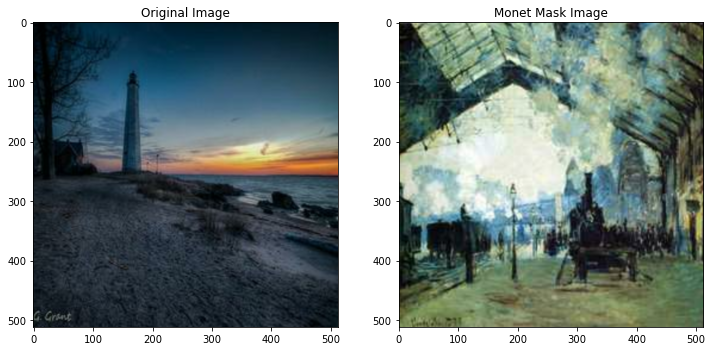

In [46]:
original_img = load_img('./images/original_jpg/6736ee186d.jpg')
monet_mask_img = load_img('./images/monet_mask_jpg/95b5f01a85.jpg')

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
show_image(original_img, title="Original Image")
plt.subplot(1,2,2)
show_image(monet_mask_img, title="Monet Mask Image")

In [31]:
print(f"Original Image Shape: {original_img.shape}")
print(f"Monet Mask Image Shape: {monet_mask_img.shape}")

Original Image Shape: (1, 512, 512, 3)
Monet Mask Image Shape: (1, 512, 512, 3)


## Preprocess original image and load VGG19 model

In [34]:
x = tf.keras.applications.vgg19.preprocess_input(original_img * 255) #Initialize model by preprocessing
x = tf.image.resize(x, (256,256)) #Input size for VGG19 model
vgg_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
vgg_model.trainable=False
vgg_model.summary()

80142336/80134624 [==============================] - 9s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

## Pick layers to replace with original and monet mask from the original model architecture

In [38]:
original_image_layers = ["block4_conv2"]
monet_mask_layers = ["block1_conv1",
                    "block2_conv1",
                    "block3_conv1",
                    "block4_conv1",
                    "block5_conv1"]

## Build custome model with your layers

In [37]:
def custom_model(layer_names):
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg_model.trainable=False
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg_model.input], outputs)
    return model

## Extract styles

In [39]:
style_extractor = custom_model(monet_mask_layers)
style_extractor_output = style_extractor(monet_mask_img*255)

## Compute the gram matrix using Einsum(from tensorflow)

In [43]:
# Define tensors by the sum of their element wise cumputation

In [45]:
def gram_matrix(input_tensor): #Shape of input is: ch, n_H, n_W
    pass